<div style="text-align: right"> __Provided on April 1 and due on April 16__ [BRI516, Spring/2019] </div>

For homework in general:
* Install `Anaconda` and create an environment with `NumPy`, `Pandas`, `Matplotlib`, `scikit-learn` in Python 3.5 
* Please upload your jupyter-notebook file for homework to `Blackboard`

### [Hw02] 

(1) Divide the Iris dataset into 80% for training and 20% for test

* Import Library

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# plot data set
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

FEATURE_NUM = 4
TOTAL_DATA = 150
TEST_SIZE = 0.2

* import algorithm

In [2]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

* Take Iris Data

In [3]:
# loading iris data set
df_iris = pd.read_csv('https://archive.ics.uci.edu/ml/' 'machine-learning-databases/iris/iris.data', header=None)
df_iris.columns = (['sepal length', 'sepal width', 'petal length', 'petal width', 'class label'])

X, y_str = df_iris.iloc[:, :FEATURE_NUM].values, df_iris.iloc[:, FEATURE_NUM].values
# change str to number
y = np.where(y_str == 'Iris-setosa', 0, np.where(y_str == 'Iris-versicolor', 1, 2))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=1, stratify=y)

feat_labels = df_iris.columns[:FEATURE_NUM]

# data와 class가 잘 나오는지 head로 간략하게 확인
df_iris.head()

,sepal length,sepal width,petal length,petal width,class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


* Standardize the d-dimensional dataset.

In [4]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

* Plot Iris data to separate train, test

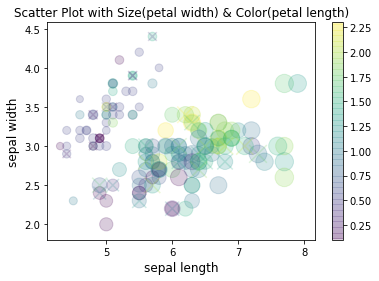

In [5]:
def plot_scatter_4D(X, y, test_idx=None):
    # setup marker generator and color map
    for idx, c1 in enumerate(np.unique(y)):
        plt.scatter(x=X[y == c1, 0], y=X[y == c1, 1], alpha=0.2,
                    s=50*X[y == c1, 2], c=X[y == c1, 3], marker='o', cmap='viridis')
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], alpha=0.2,
                    s=50*X_test[:, 2], c=X_test[:, 3], marker='x', cmap='viridis')

# plot sample data
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_scatter_4D(X=X_combined, y=y_combined, test_idx=range((TOTAL_DATA - (int)(TOTAL_DATA*TEST_SIZE)), TOTAL_DATA))

plt.title('Scatter Plot with Size(petal width) & Color(petal length)', fontsize=12)
plt.xlabel('sepal length', fontsize=12)
plt.ylabel('sepal width', fontsize=12)
plt.colorbar()
plt.show()

* Feature가 총 4개라 4-D로 plot을 하였다. 그렇게 직관적이게 보이지는 않는다.

#### Feature selection

(2) Apply feature selection algorithm, `sequential backward selection (SBS)` to select k features (k = 1, 2, 3) from the Iris data using (a) support vector machine (SVM) and (b) k-nearest neighbor (KNN) classifiers.

* define SBS class

In [6]:
class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        # Data를 train과 Test Set으로 분리
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size,random_state=self.random_state)
        
        # Feature 개수를 dim으로 저장
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        # indices에 넣은 feature 들로만 fit을 진행해서 score 값을 Get
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

* sequential backward selection (SBS)

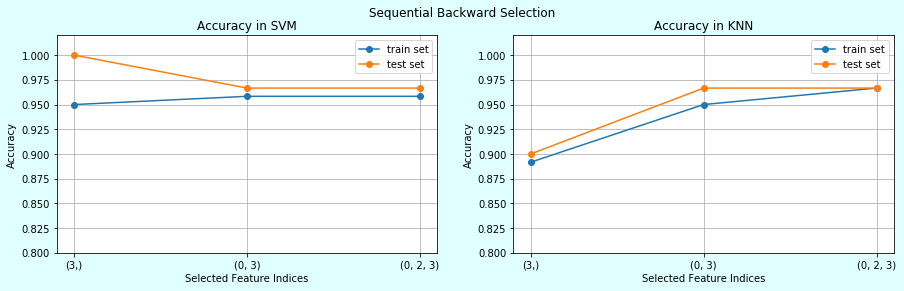

In [7]:
## SVM
svm_fs_ = SVC(kernel='rbf', C=1.0, random_state=0, gamma='scale')
sbs_svm = SBS(svm_fs_, k_features = 1, scoring=accuracy_score, test_size=0.25, random_state=1)
sbs_svm.fit(X_train_std, y_train)
k_feat = [len(k) for k in sbs_svm.subsets_]

result_train_svm_sbs = []
result_test_svm_sbs = []
for sub in sbs_svm.subsets_:
    # selecting features
    svm_fs = SVC(kernel='rbf', C=1.0, random_state=0, gamma='scale')
    svm_fs.fit(X_train_std[:,sub], y_train)
    result_train_svm_sbs.append(accuracy_score(y_train, svm_fs.predict(X_train_std[:, sub])))
    result_test_svm_sbs.append(accuracy_score(y_test, svm_fs.predict(X_test_std[:, sub])))
    
## KNN
knn_fs_ = KNeighborsClassifier(n_neighbors=2)
# selecting features
sbs_knn = SBS(knn_fs_, k_features=1)
sbs_knn.fit(X_train_std, y_train)
k_feat_knn = [len(k) for k in sbs_knn.subsets_]

result_train_knn_sbs = []
result_test_knn_sbs = []
for sub in sbs_knn.subsets_:
    # selecting features
    knn_fs = KNeighborsClassifier(n_neighbors=2)
    knn_fs.fit(X_train_std[:,sub], y_train)
    result_train_knn_sbs.append(accuracy_score(y_train, knn_fs.predict(X_train_std[:, sub])))
    result_test_knn_sbs.append(accuracy_score(y_test, knn_fs.predict(X_test_std[:, sub])))
    
############################
fig = plt.figure(figsize=(15,4))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('Sequential Backward Selection')

ax = fig.subplots(1,2)
ax[0].set_title('Accuracy in SVM')
ax[0].plot(k_feat[1:], np.vstack((result_train_svm_sbs[1:], result_test_svm_sbs[1:])).T, marker='o')
ax[0].set_ylim(0.8, 1.02)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Selected Feature Indices')
ax[0].set_xticks(k_feat[1:])
ax[0].set_xticklabels(sbs_svm.subsets_[1:])
ax[0].grid()
ax[0].legend(['train set','test set'])


ax[1].set_title('Accuracy in KNN')
ax[1].plot(k_feat_knn[1:], np.vstack((result_train_knn_sbs[1:], result_test_knn_sbs[1:])).T, marker='o')
ax[1].set_ylim(0.8, 1.02)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Selected Feature Indices')
ax[1].set_xticks(k_feat[1:])
ax[1].set_xticklabels(sbs_svm.subsets_[1:])
ax[1].grid()
ax[1].legend(['train set','test set'])

* index 2 > index 0 의 순으로 feature를 제거하였는데, SVM의 경우 feature 수가 두 개가 되어도 feature 전부를 사용한 경우에 비해 performance가 줄어들지 않았다.(KNN도 그렇게 많이 차이나지 않는 performance를 보여주고 있다)
* 적은 feature로도 classification이 잘 되는 것을 보여주며 computational resource를 낮출수 있음을 알수 있다.

(3) Perform the selection of k features (k = 1, 2, 3) using `feature_importances_` attribute from the random forest (RF) classifier

 1) petal length                   0.427366
 2) petal width                    0.405946
 3) sepal length                   0.134716


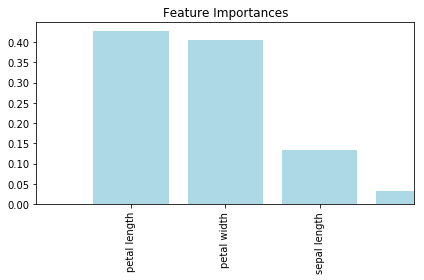

In [8]:
forest_fs = RandomForestClassifier(n_estimators=50, random_state=1, n_jobs=-1)

forest_fs.fit(X_train, y_train)
importances = forest_fs.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]-1):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color='lightblue', align='center')

plt.xticks(range(X_train.shape[1] - 1), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1] - 1])
plt.tight_layout()
plt.show()

* petal length(2) > petal width(3) > sepal length(0) 순으로 k의 feature가 classification에 중요한 것을 알 수 있다.
(k를 3, 2, 1으로만 확인하면 되기에 더 적지는 않음)
* k = 3부터 1까지 중요도가 낮은 feature를 하나씩 빼서 subset을 만들어 performance 확인

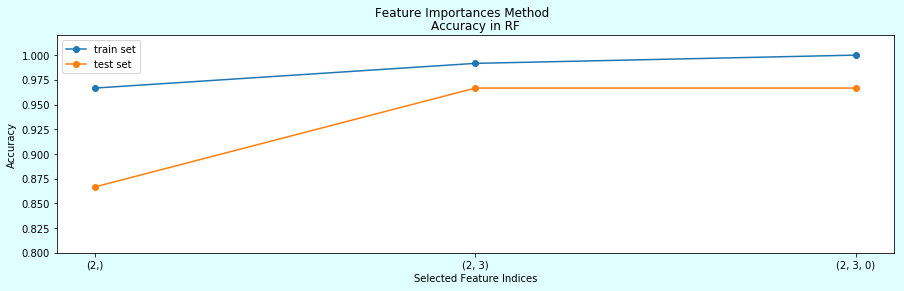

In [9]:
subset = []
k_feat_rf = []
i_importance = np.argsort(importances)[::-1]
for i in range(3, 0, -1):
    subset.append((tuple(i_importance[:i])))
    k_feat_rf.append(i)

# Performance
result_train_rf_fs = []
result_test_rf_fs = []

for sub in subset:
    clf = RandomForestClassifier(criterion='gini',n_estimators=50,random_state=1,n_jobs=2)
    clf.fit(X_train_std[:,sub],y_train)
    result_train_rf_fs.append(accuracy_score(y_train,clf.predict(X_train_std[:, sub])))
    result_test_rf_fs.append(accuracy_score(y_test, clf.predict(X_test_std[:, sub])))

fig = plt.figure(figsize=(15,4))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('Feature Importances Method')

ax = fig.subplots(1,1)
ax.set_title('Accuracy in RF')
ax.plot(k_feat_rf, np.vstack((result_train_rf_fs, result_test_rf_fs)).T, marker='o')
ax.set_ylim(0.8, 1.02)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Selected Feature Indices')
ax.set_xticks(k_feat_rf)
ax.set_xticklabels((subset))
ax.legend(['train set','test set'])

* Feature Importances를 사용하여 중요도가 높은 Feature부터 subset으로 사용하였기 때문에 Accuracy가 급격히 떨어지지는 않는다. 
* petal length가 가장 중요하고 petal width가 그렇게 많은 차이없이 그 다음으로 중요하기 때문에 세개에서 두개까지는 그렇게 많은 Accuracy 차이를 보이지 않는것을 알수 있다.

(4) Discuss the results

* Feature  Selection에서 SVM(SBS) -> KNN(SBS) -> RF(Feature Importance Method)순으로 Iris data set에서는 performance를 보이고 있다. Feature Importance method도 좋지만 SBS가 기본적으로 더 좋은 성능을 보이고 있다.

#### Feature extraction

(5) Apply feature extraction methods using (a) principal component analysis (PCA) and (b) linear discriminant analysis (LDA) to extract k features (k = 1, 2, 3)

#### (a) principal component analysis (PCA)

In [10]:
"""
 PCA : Unsupervised data compression with the goal of maintaining most of the relevant information.
       (unsupervised linear transformation technique)

    step:
    1. Standardize the d-dimensional dataset.
    2. Construct the covariance matrix.
    3. Decompose the covariance matrix into its eigenvectors and eigenvalues.
    4. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.
    5. Select k eigenvectors which correspond to the k largest eigenvalues, 
       where k is the dimensionality of the new feature subspace (k<=d)
    6. Construct a projection matrix W from the "top" k eigenvectors.
    7. Transform the d-dimensional input dataset X using the projection matrix W
       to obtain the new k-dimensional feature subspace.
"""

# 2. Construct the covariance matrix.
cov_mat = np.cov(X_train_std.T)

# 3. Decompose the covariance matrix into its eigenvectors(principle components) and eigenvalues(magnitude).
#    (4 x 4-dimensional covariance matrix)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\n* Eigenvalues:\n{}'.format(eigen_vals))


* Eigenvalues:
[2.95073025 0.92599475 0.13437905 0.02250939]


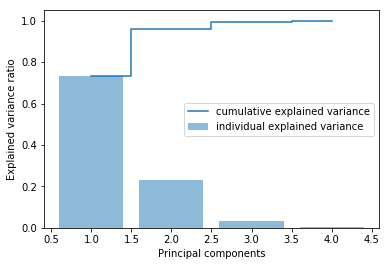

In [11]:
# 4. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.

## Total and explained variance
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, 5), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, 5), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

* 첫번째 Principle component로는 약 71% 정도의 variance를 설명할 수 있고, 2개의 principle component 결합으로는 약94% 정도의 variance를 설명할 수 있으며, 처음으로부터 3개의 principle component의 결합으로는 약99%의 variance를 설명할 수 있다.

In [12]:
# 5. Select k eigenvectors which correspond to the k largest eigenvalues, 
#    where k is the dimensionality of the new feature subspace (k<=d)

# Feature transformation
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# 6. Construct a projection matrix W from the "top" k eigenvectors.
""" 
    k = 1, W1 = 4x1 matrix, k = 2, W2 = 4x2 matrix, k = 3, W3 = 4x3 matrix 
"""
W = eigen_pairs[0][1][:, np.newaxis]
for i in range(FEATURE_NUM - 1):
    W_ = eigen_pairs[i + 1][1][:, np.newaxis]
    W = np.hstack((W, W_))
print('Matrix W:\n', W)

# 7. Transform the d-dimensional input dataset X using the projection matrix W
#    to obtain the new k-dimensional feature subspace.
nX_train_pca = []
nX_test_pca = []

for i in range(3): # k=1부터 3까지
    nX_train_pca.append(X_train_std.dot(W[:,0:i+1]))
    nX_test_pca.append(X_test_std.dot(W[:,0:i+1]))
    
from mpl_toolkits.mplot3d import Axes3D # This import registers the 3D projection
def plot_scatter_pca(X1, X2, X3, y, k=None):
    colors = ['r', 'b', 'g']
    markers = ['s', 'x', 'o']
    
    fig = plt.figure(figsize=(15, 3))
    
    # k = 1
    ax1 = fig.add_subplot(1, 3, 1)
    for l, c, m in zip(np.unique(y), colors, markers):
        ax1.scatter(X1[y == l, 0], np.zeros((np.size(X1[y == l, 0]))) + 0.02, c=c, label=l, marker=m)
    ax1.set_title('k=1')
    ax1.set_xlabel('PC1')
    ax1.set_yticks([])
    ax1.legend(loc='upper right')

    # k = 2
    ax2 = fig.add_subplot(1, 3, 2)
    for l, c, m in zip(np.unique(y), colors, markers):
        ax2.scatter(X2[y == l, 0], X2[y == l, 1], c=c, label=l, marker=m)
    ax2.set_title('k=2')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    ax2.legend(loc='upper right')

    # k = 3
    ax3 = fig.add_subplot(1, 3, 3, projection='3d', elev=40, azim=-110)
    for l, c, m in zip(np.unique(y), colors, markers):
        ax3.scatter(X3[y == l, 0], X3[y == l, 1], X3[y == l, 2], c=c, label=l, marker=m)
    ax3.set_title('k=3')
    ax3.set_xlabel('PC1')
    ax3.set_ylabel('PC2')
    ax3.set_zlabel('PC3')
    ax3.legend(loc='upper right')

Matrix W:
 [[ 0.52797079 -0.34969095 -0.72721657  0.26480021]
 [-0.25651575 -0.93379065  0.21987793 -0.11784901]
 [ 0.57943367 -0.02483395  0.1404262  -0.8024465 ]
 [ 0.56542298 -0.07165569  0.63489388  0.52160529]]


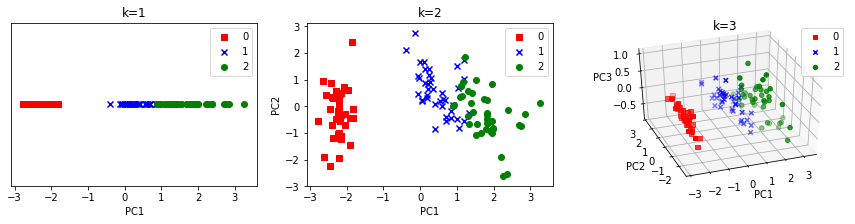

In [13]:
# k = 1, 2, 3 (train)
plot_scatter_pca(nX_train_pca[0], nX_train_pca[1], nX_train_pca[2], y_train)

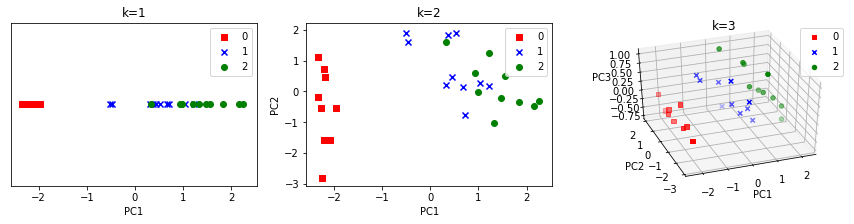

In [14]:
# k = 1, 2, 3 (test)
plot_scatter_pca(nX_test_pca[0], nX_test_pca[1], nX_test_pca[2], y_test)

* PCA로 data 분류시, k=3정도 되어야 data가 linear하게 보이는 것을 확인할 수 있다. unsupervised라 label이 없어서 그런것 같다.

#### (b) linear discriminant analysis (LDA)

In [15]:
# Computing the scatter matrices
# Calculate the mean vectors for each class:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(0, 3):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s' % (label, mean_vecs[label - 1]))

# Compute the within-class scatter matrix
d = FEATURE_NUM  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(0, 3), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print('\nScaled within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

# Compute the between-class scatter matrix
mean_overall = np.mean(X_train_std, axis=0)
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    mean_overall = mean_overall.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

# Solve the generalized eigenvalue problem for the matrix
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

MV 0: [-1.0401  0.8179 -1.3077 -1.2542]
MV 1: [-1.0401  0.8179 -1.3077 -1.2542]
MV 2: [ 0.0845 -0.6603  0.2831  0.1677]

Scaled within-class scatter matrix: 4x4
Between-class scatter matrix: 4x4



* Eigenvalues in decreasing order:
798.6388177779836
5.739467300797542
1.2300014548154071e-13
1.4924920938746193e-14


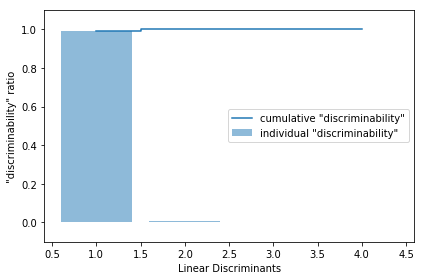

In [16]:
# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('\n* Eigenvalues in decreasing order:')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, FEATURE_NUM+1), discr, alpha=0.5, align='center', label='individual "discriminability"')
plt.step(range(1, FEATURE_NUM+1), cum_discr, where='mid', label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

class label을 제공해서 확인시, 하나의 eigen value 만으로도 거의 98%의 variance를 설명할 수 있다.

In [17]:
# projection matrix
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
               eigen_pairs[1][1][:, np.newaxis].real,
               eigen_pairs[2][1][:, np.newaxis].real,
               eigen_pairs[3][1][:, np.newaxis].real))
print('Matrix W:\n', w)

# Projecting samples onto the new feature space (max k = 3)
nX_train_lda = []
nX_test_lda = []

for i in range(3): # k=1부터 3까지
    nX_train_lda.append(X_train_std.dot(w[:,0:i+1]))
    nX_test_lda.append(X_test_std.dot(w[:,0:i+1]))

def plot_scatter_lda(X1, X2, X3, y, k=None):
    colors = ['r', 'b', 'g']
    markers = ['s', 'x', 'o']
    
    fig = plt.figure(figsize=(15, 3))
    
    # k = 1
    ax1 = fig.add_subplot(1, 3, 1)
    for l, c, m in zip(np.unique(y), colors, markers):
        ax1.scatter(X1[y == l, 0], np.zeros((np.size(X1[y == l, 0]))) + 0.02, c=c, label=l, marker=m)
    ax1.set_title('k=1')
    ax1.set_xlabel('LD1')
    ax1.set_yticks([])
    ax1.legend(loc='upper right')

    # k = 2
    ax2 = fig.add_subplot(1, 3, 2)
    for l, c, m in zip(np.unique(y), colors, markers):
        ax2.scatter(X2[y == l, 0], X2[y == l, 1], c=c, label=l, marker=m)
    ax2.set_title('k=2')
    ax2.set_xlabel('LD1')
    ax2.set_ylabel('LD2')
    ax2.legend(loc='upper right')

    # k = 3
    ax3 = fig.add_subplot(1, 3, 3, projection='3d', elev=40, azim=-110)
    for l, c, m in zip(np.unique(y), colors, markers):
        ax3.scatter(X3[y == l, 0], X3[y == l, 1], X3[y == l, 2], c=c, label=l, marker=m)
    ax3.set_title('k=3')
    ax3.set_xlabel('LD1')
    ax3.set_ylabel('LD2')
    ax3.set_zlabel('LD3')
    ax3.legend(loc='upper right')

Matrix W:
 [[-0.142  -0.1206  0.0198  0.8172]
 [-0.1382 -0.2568  0.1398 -0.169 ]
 [ 0.9024  0.6078  0.7217 -0.4481]
 [ 0.3826 -0.7417 -0.6777 -0.3207]]


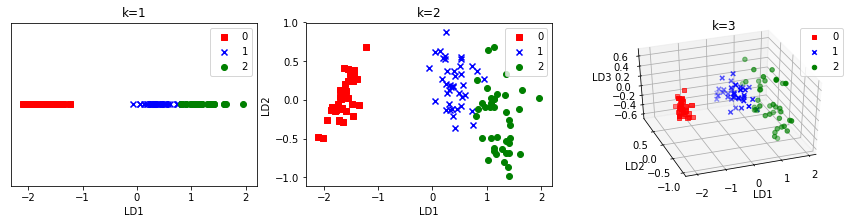

In [18]:
# k = 1, 2, 3 (train)
plot_scatter_lda(nX_train_lda[0], nX_train_lda[1], nX_train_lda[2], y_train)

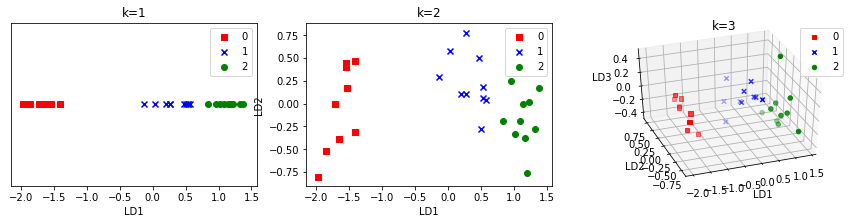

In [19]:
# k = 1, 2, 3 (test)
plot_scatter_lda(nX_test_lda[0], nX_test_lda[1], nX_test_lda[2], y_test)

* LDA로 분류한것이 PCA로 분류하는 것보다 data를 더 잘설명하는 것을 확인할 수 있다. class label에 따른 영향으로 보인다.

(6) Perform the classification of the Iris data with k-dimensional extracted features from (5) using (a) support vector machine (SVM), (b) KNN, and (c) RF classifiers

### PCA

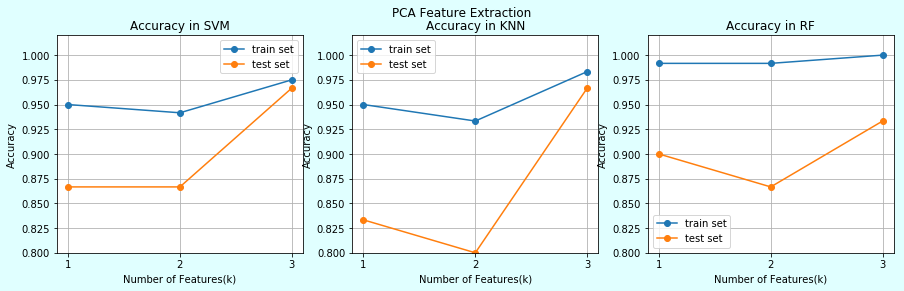

In [20]:
# Performance
## SVM
result_train_svm_pca = []
result_test_svm_pca = []
for f in range(3):
    result_svm_pca = SVC(kernel='rbf', C=1.0, random_state=0, gamma='scale')
    result_svm_pca.fit(nX_train_pca[f], y_train)
    result_train_svm_pca.append(accuracy_score(y_train, result_svm_pca.predict(nX_train_pca[f])))
    result_test_svm_pca.append(accuracy_score(y_test, result_svm_pca.predict(nX_test_pca[f])))

## KNN
result_train_knn_pca = []
result_test_knn_pca = []
for f in range(3):
    result_knn_pca = KNeighborsClassifier(n_neighbors=2)
    result_knn_pca.fit(nX_train_pca[f], y_train)
    result_train_knn_pca.append(accuracy_score(y_train, result_knn_pca.predict(nX_train_pca[f])))
    result_test_knn_pca.append(accuracy_score(y_test, result_knn_pca.predict(nX_test_pca[f])))

## RF
result_train_rf_pca = []
result_test_rf_pca = []
for f in range(3):
    result_rf_pca = RandomForestClassifier(criterion='gini',n_estimators=30,random_state=1,n_jobs=2)
    result_rf_pca.fit(nX_train_pca[f], y_train)
    result_train_rf_pca.append(accuracy_score(y_train, result_rf_pca.predict(nX_train_pca[f])))
    result_test_rf_pca.append(accuracy_score(y_test, result_rf_pca.predict(nX_test_pca[f])))
    
######################
fig = plt.figure(figsize=(15,4))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('PCA Feature Extraction')

ax = fig.subplots(1,3)
ax[0].set_title('Accuracy in SVM')
ax[0].plot(np.array(range(3))+1, np.vstack((result_train_svm_pca, result_test_svm_pca)).T, marker='o')
ax[0].set_ylim(0.8, 1.02)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Number of Features(k)')
ax[0].set_xticks(np.array(range(3))+1)
ax[0].grid()
ax[0].legend(['train set','test set'])

ax[1].set_title('Accuracy in KNN')
ax[1].plot(np.array(range(3))+1, np.vstack((result_train_knn_pca, result_test_knn_pca)).T, marker='o')
ax[1].set_ylim(0.8, 1.02)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of Features(k)')
ax[1].set_xticks(np.array(range(3))+1)
ax[1].grid()
ax[1].legend(['train set','test set'])

ax[2].set_title('Accuracy in RF')
ax[2].plot(np.array(range(3))+1, np.vstack((result_train_rf_pca, result_test_rf_pca)).T, marker='o')
ax[2].set_ylim(0.8, 1.02)
ax[2].set_ylabel('Accuracy')
ax[2].set_xlabel('Number of Features(k)')
ax[2].set_xticks(np.array(range(3))+1)
ax[2].grid()
ax[2].legend(['train set','test set'])

#### PCA 결과
* k값이 증가할 수록 정확도가 올라가는 결과가 도출되었다.
* 전반적으로 봤을때는 SVM이 가장 좋고 그다음 KNN 이후 RF순으로 k값이 증가할수록 성능이 좋아지는것을 확인할수 있다

### LDA

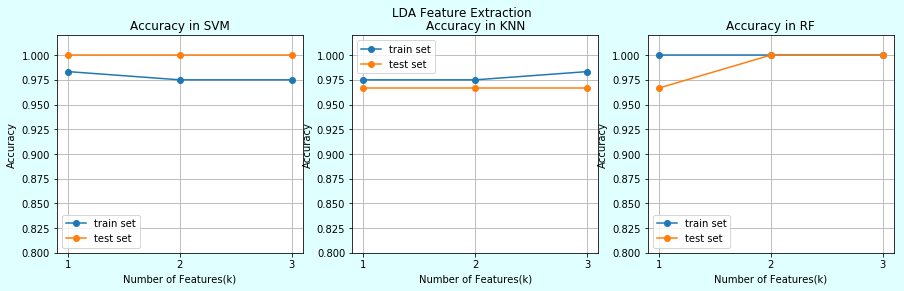

In [21]:
# Performance
## SVM
result_train_svm_lda = []
result_test_svm_lda = []
for f in range(3):
    result_svm_lda = SVC(kernel='rbf', C=1.0, random_state=0, gamma='scale')
    result_svm_lda.fit(nX_train_lda[f], y_train)
    result_train_svm_lda.append(accuracy_score(y_train, result_svm_lda.predict(nX_train_lda[f])))
    result_test_svm_lda.append(accuracy_score(y_test, result_svm_lda.predict(nX_test_lda[f])))

## KNN
result_train_knn_lda = []
result_test_knn_lda = []
for f in range(3):
    result_knn_lda = KNeighborsClassifier(n_neighbors=2)
    result_knn_lda.fit(nX_train_lda[f], y_train)
    result_train_knn_lda.append(accuracy_score(y_train, result_knn_lda.predict(nX_train_lda[f])))
    result_test_knn_lda.append(accuracy_score(y_test, result_knn_lda.predict(nX_test_lda[f])))

## RF
result_train_rf_lda = []
result_test_rf_lda = []
for f in range(3):
    result_rf_lda = RandomForestClassifier(criterion='gini',n_estimators=300,random_state=1,n_jobs=2)
    result_rf_lda.fit(nX_train_lda[f], y_train)
    result_train_rf_lda.append(accuracy_score(y_train, result_rf_lda.predict(nX_train_lda[f])))
    result_test_rf_lda.append(accuracy_score(y_test, result_rf_lda.predict(nX_test_lda[f])))
    
######################
fig = plt.figure(figsize=(15,4))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('LDA Feature Extraction')

ax = fig.subplots(1,3)
ax[0].set_title('Accuracy in SVM')
ax[0].plot(np.array(range(3))+1, np.vstack((result_train_svm_lda, result_test_svm_lda)).T, marker='o')
ax[0].set_ylim(0.8, 1.02)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Number of Features(k)')
ax[0].set_xticks(np.array(range(3))+1)
ax[0].grid()
ax[0].legend(['train set','test set'])

ax[1].set_title('Accuracy in KNN')
ax[1].plot(np.array(range(3))+1, np.vstack((result_train_knn_lda, result_test_knn_lda)).T, marker='o')
ax[1].set_ylim(0.8, 1.02)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of Features(k)')
ax[1].set_xticks(np.array(range(3))+1)
ax[1].grid()
ax[1].legend(['train set','test set'])

ax[2].set_title('Accuracy in RF')
ax[2].plot(np.array(range(3))+1, np.vstack((result_train_rf_lda, result_test_rf_lda)).T, marker='o')
ax[2].set_ylim(0.8, 1.02)
ax[2].set_ylabel('Accuracy')
ax[2].set_xlabel('Number of Features(k)')
ax[2].set_xticks(np.array(range(3))+1)
ax[2].grid()
ax[2].legend(['train set','test set'])

#### LDA 결과
* k값이 작아도 좋은 결과가 도출되었다.
* 전반적으로 봤을때는 SVM이 가장 좋고 그다음 RF 이후 KNN순으로 성능이 좋은 것을 확인할수 있다
* class label을 사용하기 때문에 PCA보다 좋은 성능을 보이는 것을 알수 있다.
* k=1 인 경우에도 90% 이상의 variance를 설명한 explained variance 그래프와 어느정도 일치함을 알수 있다.

(7) Discuss the results in comparison to (4)

* LDA -> SBS -> PCA 순으로 좋은 성능을 보이고 있다. PCA 성능이 떨어지는 이유는 class label을 고려하지 않아서 조금 성능이 않좋은것 같다.
* 전반적으로 Feature Selection이나 Feature Extraction이나 성능을 봤을때에, Feature의 개수를 좀 줄여도 비슷한 결과가 나오는것을 봐서는 computational resource를 줄여줄수 있을것으로 확인 된다.

Note
* Set appropriate hyperparameter values (i.e., number of iterations, number of estimators, distance measure and so on) to get a reasonable performance
* Draw an accuracy plot on both training and test set where applicable 
* Draw plots using the Matplotlib
* Please explain your results 